# Dialoge-Act Recognition

3-layered neural network trained on NPS Chat corpus in order to recognize an act from a given dialoge. The NPS corpus consists of conversations from Chat room and has pos tagging as well as dialoge-act tagging. The complete corpus consists of  15 different tags in total for dialoge-act. For simplicity, I have considered only 3 tags:'Greet', 'Emotion', and 'Bye'. 

In [64]:
import nltk
from nltk.corpus import nps_chat as nps
from collections import Counter
import numpy as np
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [128]:
posts = nps.xml_posts()
np.random.seed(1)

In [117]:
acts = [posts[i].get('class') for i in range(len(posts))]
print('Different Acts: ')
print(set(acts), '\n')
print('Acts Occruances: ')
print(Counter(acts))

Different Acts: 
{'Greet', 'Reject', 'Clarify', 'yAnswer', 'nAnswer', 'Other', 'Continuer', 'ynQuestion', 'Emotion', 'whQuestion', 'System', 'Emphasis', 'Accept', 'Bye', 'Statement'} 

Acts Occruances: 
Counter({'Statement': 3185, 'System': 2632, 'Greet': 1363, 'Emotion': 1106, 'ynQuestion': 550, 'whQuestion': 533, 'Accept': 233, 'Bye': 195, 'Emphasis': 190, 'Continuer': 168, 'Reject': 159, 'yAnswer': 108, 'nAnswer': 72, 'Clarify': 38, 'Other': 35})


In [118]:
#considering only 'Greet', 'Emotion', and 'Bye'
act_labels = ['Greet', 'Emotion', 'Bye']
posts = [posts[i] for i in range(len(posts)) if posts[i].get('class') in act_labels] 
sentences = [posts[i].text for i in range(len(posts))]
labels = [posts[i].get('class') for i in range(len(posts))]
print(sentences)
print(labels)

[':P', 'hey everyone  ', ':)', 'hi 10-19-20sUser59', 'boo.', 'lol 10-19-20sUser115', 'boo.', 'boo.', 'ewwwww lol', 'heeeey!', 'hey ladies', 'hey ', 'yo, 10-19-20sUser133', ':)', 'haha', 'brb', 'opps', 'hi there', 'hey 10-19-20sUser126', 'yeee haw 10-19-20sUser30', 'hi 10-19-20sUser64', 'wb 10-19-20sUser139', 'Hi 10-19-20sUser139', 'hi 10-19-20sUser138', 'HAHAHA', 'hi 10-19-20sUser139.', 'hi 10-19-20sUser126, its so late', 'lmao', 'Hi 10-19-20sUser121', 'cya later guys', 'hi 10-19-20sUser139', 'bye 10-19-20sUser20', ':)', 'lol 10-19-20sUser7', 'Hi 10-19-20sUser115', 'OOooOO:)', 'lmaoo 10-19-20sUser121', 'hiya room', 'lmao!!!', 'omg', 'yay!', 'geeshhh', 'lol 10-19-20sUser6', 'lol 10-19-20sUser121!!!', 'lol', 'Hi all 31/m/CA', 'lmao 10-19-20sUser7!!!', ':)', 'lolololll serg!!!', 'lol', 'lmao', 'awwwwww', ':(', 'lol', 'heyy 10-19-20sUser148', 'i hate you.', 'bye  10-19-20sUser148', 'ahahah 10-19-20sUser7!!', 'Lmfao', 'wouldnt let her date', 'aww.', 'hello 10-19-20sUser84', 'hello room', 'l

In [119]:
#creating dataset
words = []
dialoges = []
for i in sentences:
    w = nltk.word_tokenize(i)
    words.extend(w)
    dialoges.append(w)
print(dialoges)

[[':', 'P'], ['hey', 'everyone'], [':', ')'], ['hi', '10-19-20sUser59'], ['boo', '.'], ['lol', '10-19-20sUser115'], ['boo', '.'], ['boo', '.'], ['ewwwww', 'lol'], ['heeeey', '!'], ['hey', 'ladies'], ['hey'], ['yo', ',', '10-19-20sUser133'], [':', ')'], ['haha'], ['brb'], ['opps'], ['hi', 'there'], ['hey', '10-19-20sUser126'], ['yeee', 'haw', '10-19-20sUser30'], ['hi', '10-19-20sUser64'], ['wb', '10-19-20sUser139'], ['Hi', '10-19-20sUser139'], ['hi', '10-19-20sUser138'], ['HAHAHA'], ['hi', '10-19-20sUser139', '.'], ['hi', '10-19-20sUser126', ',', 'its', 'so', 'late'], ['lmao'], ['Hi', '10-19-20sUser121'], ['cya', 'later', 'guys'], ['hi', '10-19-20sUser139'], ['bye', '10-19-20sUser20'], [':', ')'], ['lol', '10-19-20sUser7'], ['Hi', '10-19-20sUser115'], ['OOooOO', ':', ')'], ['lmaoo', '10-19-20sUser121'], ['hiya', 'room'], ['lmao', '!', '!', '!'], ['omg'], ['yay', '!'], ['geeshhh'], ['lol', '10-19-20sUser6'], ['lol', '10-19-20sUser121', '!', '!', '!'], ['lol'], ['Hi', 'all', '31/m/CA'], [

In [120]:
#creating vocabulary
ignore_words = ['?']
sno = nltk.stem.SnowballStemmer('english')
words = [sno.stem(w.lower()) for w in words if w not in ignore_words]
words = list(set(words))
print(words)

['haha', 'hb', 'bike', 'sit', 'lmaooo', 'amaz', '10-19-40suser3', '10-24-40suser34_', '11-08-40suser46..', '11-08-adultsuser39', '10-19-30suser11', 're', 'uffff', 'wan', ';', '11-08-40suser47', 'no', 'hih', '11-06-adultsuser67', 'dog', 'oi', '10-19-40suser55', 'yay', '10-24-40suser14', '11-09-40suser35..', 'brb..', '11-09-teensuser104', 'o.o', "n't", 'fli', 'ho', 'paradi', '..lol', 'come', 'your', '11-09-adultsuser53', 'slkfjsldkfjs', 'jesus', 'sean', '11-09-20suser156', 'awwww', '11-08-20suser130', '10-19-40suser44..', '11-08-20suser121', '26', 'kold', 'just', 'do', 'bbs', '10-19-adultsuser38', 'heyi', '3', 'suppos', 'geeshhh', '11-08-40suser37', '11-08-40suser32', '10-24-40suser38', '10-19-adultsuser40', 'jimmi', 'brb..popcorn', 'ahahh', 'hhehe', 'gn', 'room..anyon', 'easi', 'ugh', 'o_o', 'bright', 'wahoooooooo', '11-06-adultsuser103', '11-09-20suser34', '3333', '10-19-40suser42', 'norman', 'around', '^_^', '11-08-teensuser144', 'rock', 'mornin', 'wave', 'hug', 'hendrix', '11-09-20su

In [121]:
#create bag-of-words
def get_bof(dialoges):
    dataset = []
    for dialoge in dialoges:
        bag = []
        sent = [sno.stem(w.lower()) for w in dialoge if w not in ignore_words]
        for w in words:
            bag.append(1) if w in sent else bag.append(0)
        dataset.append(bag)
    dataset = np.array(dataset)
    return dataset

dataset = get_bof(dialoges)

In [122]:
#one-hot encoding of labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)
labels = label_encoder.transform(labels)
labels = np_utils.to_categorical(labels, num_classes=3)
labels

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [123]:
print('input shape: ', dataset.shape)
print('output shape: ', labels.shape)

input shape:  (2664, 1206)
output shape:  (2664, 3)


In [129]:
#define model architecture
model = Sequential()
model.add(Dense(units=512, input_dim=dataset.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dense(units=labels.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(dataset, labels, validation_split=0.2, epochs=5, batch_size=32, verbose=1)

Train on 2131 samples, validate on 533 samples
Epoch 1/5
2131/2131 [==============================] - 1s 605us/step - loss: 4.4858 - acc: 0.7860 - val_loss: 1.0400 - val_acc: 0.8518
Epoch 2/5
2131/2131 [==============================] - 1s 306us/step - loss: 0.4654 - acc: 0.9277 - val_loss: 0.3299 - val_acc: 0.9287
Epoch 3/5
2131/2131 [==============================] - 1s 379us/step - loss: 0.1837 - acc: 0.9836 - val_loss: 0.2602 - val_acc: 0.9362
Epoch 4/5
2131/2131 [==============================] - 1s 352us/step - loss: 0.1247 - acc: 0.9906 - val_loss: 0.2200 - val_acc: 0.9475
Epoch 5/5
2131/2131 [==============================] - 1s 333us/step - loss: 0.0930 - acc: 0.9925 - val_loss: 0.2061 - val_acc: 0.9437


Text(0.5,1,'Validation vs Train Loss')

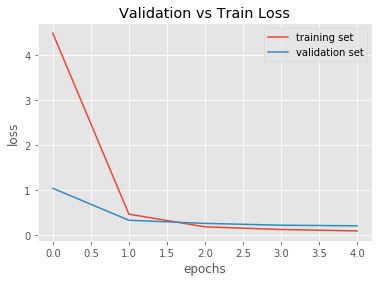

In [130]:
#visualize model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training set', 'validation set'], loc='best')
plt.title('Validation vs Train Loss')

Text(0.5,1,'Validation vs Train Accuracy')

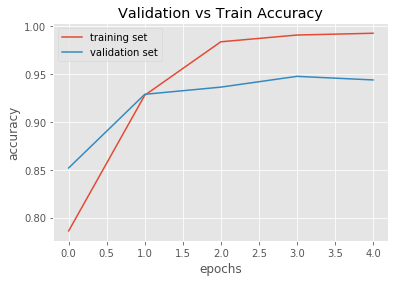

In [131]:
#visualize model accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training set', 'validation set'], loc='best')
plt.title('Validation vs Train Accuracy')

In [132]:
#let's make some predictions
my_data = ['What’s up?', 'I am not feeling well!!', 'Take care', 'Okay, see you later', 'How’s life?', 'I’m off']
my_data = [nltk.word_tokenize(w) for w in my_data]
my_data = get_bof(my_data)
label_prob = model.predict(my_data) 
label_pred = label_prob.argmax(axis=-1)
print(y_pred)
print(label_encoder.inverse_transform(y_pred))

[2 1 1 0 2 0]
['Greet' 'Emotion' 'Emotion' 'Bye' 'Greet' 'Bye']


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
